In [1]:
import stata_setup

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
stata_setup.config('/usr/local/stata17', 'be')


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       BE—Basic Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user , expiring 16 Apr 2023
Serial number: 301709041865
  Licensed to: Tomas Protivinsky
               CERGE-EI

Notes:
      1. Unicode is supported; see help unicode_advice.


In [18]:
%%stata
// kod
clear all
version 17
set more off
// global path to data
global PATHD="/mnt/d/projects/idea/data"

quiet import spss ${PATHD}/PISA/2018/CZ/CY07_MSU_STU_QQQ_FINAL_CZ.sav, clear

// 1. PŘÍPRAVA DAT
// zde spoléhám na to, že pohlaví mám u všech - v datasetu to platí
gen girl = (ST004D01T == 1)
keep if (ST001D01T == "Grade 9":labels3 & STRATUMID_rec == "ZŠ":labels2)

gen gr_matematika = ST800C01HA_CZ
gen gr_cestina = ST800C02HA_CZ

// recode gr_matematika 1=1 2=2 3=5 4=4 5=3 6 .=.
// recode gr_cestina 1=1 2=2 3=5 4=4 5=3 6 .=.
recode gr_matematika 3=5 5=3 6=.
recode gr_cestina 6=.

// podívejme se ještě na přírodovědu
recode ST800C04HA_CZ 6=.
recode ST800C05HA_CZ 6=.
recode ST800C06HA_CZ 6=.

egen gr_science = rowmean(ST800C04HA_CZ ST800C05HA_CZ ST800C06HA_CZ)

egen gr_matematika_z = std(gr_matematika)
egen gr_cestina_z = std(gr_cestina)
egen gr_science_z = std(gr_science)



// all this stuff has to be run at once
tempfile stu18
save `stu18'

quiet import spss ${PATHD}/PISA/2018/CZ/CY07_MSU_SCH_QQQ_FINAL_CZ.sav, clear
keep CNTSCHID W_SCHGRNRABWT
tempfile sch18
save `sch18'

use `stu18'
merge m:1 CNTSCHID using `sch18'
// je dobré zkontrolovat, že je to v pořádku namergované
drop if _merge==2 

// 2. ANALÝZA
gen math=1/0
gen read=1/0
gen scie=1/0
mi import wide, imputed(math=PV*MATH read=PV*READ scie=PV*SCIE) clear

qui mi passive: egen mathz = std(math)
qui mi passive: egen readz = std(read)
qui mi passive: egen sciez = std(scie)
egen ESCSz = std(ESCS)



. // kod
. clear all

. version 17

. set more off

. // global path to data
. global PATHD="/mnt/d/projects/idea/data"

. 
. quiet import spss ${PATHD}/PISA/2018/CZ/CY07_MSU_STU_QQQ_FINAL_CZ.sav, clear

. 
. // 1. PŘÍPRAVA DAT
. // zde spoléhám na to, že pohlaví mám u všech - v datasetu to platí
. gen girl = (ST004D01T == 1)

. keep if (ST001D01T == "Grade 9":labels3 & STRATUMID_rec == "ZŠ":labels2)
(4,832 observations deleted)

. 
. gen gr_matematika = ST800C01HA_CZ
(290 missing values generated)

. gen gr_cestina = ST800C02HA_CZ
(293 missing values generated)

. 
. // recode gr_matematika 1=1 2=2 3=5 4=4 5=3 6 .=.
. // recode gr_cestina 1=1 2=2 3=5 4=4 5=3 6 .=.
. recode gr_matematika 3=5 5=3 6=.
(592 changes made to gr_matematika)

. recode gr_cestina 6=.
(15 changes made to gr_cestina)

. 
. // podívejme se ještě na přírodovědu
. recode ST800C04HA_CZ 6=.
(12 changes made to ST800C04HA_CZ)

. recode ST800C05HA_CZ 6=.
(13 changes made to ST800C05HA_CZ)

. recode ST800C06HA_CZ 6=.
(

In [9]:
%%stata
preserve

In [12]:
from pystata import stata

In [22]:
gr = 1
q = 0.05

stata.run(f'''
    preserve
    keep if gr_matematika == {gr}
    mi estimate, dots: qreg math [pw = W_FSTUWT], q({q})
    restore
''', quietly=True)
stata.get_ereturn()['e(b_mi)'][0][0]

409.78710021972654

In [16]:
stata.get_ereturn()['e(b_mi)'][0][0]

409.78710021972654

In [29]:
dd = {1: 'a'}
for k in dd.items():
    print(k[1])

a


In [30]:
boxplots = []

bxp_def = {
    'med': 0.5,
    'q1': 0.25,
    'q3': 0.75,
    'whislo': 0.05,
    'whishi': 0.95
}


for gr in range(1, 6):
    print(f'running {gr}')
    inner = {}
    inner['label'] = gr
    inner['fliers'] = []
    if gr < 5:
        cmd = 'qreg math [pw = W_FSTUWT]'
    else:
        cmd = 'bsqreg math'
    for lbl, q in bxp_def.items():        
        stata.run(f'''
            preserve
            keep if gr_matematika == {gr}
            mi estimate, dots: {cmd}, q({q})
            restore
        ''', quietly=True)
        inner[lbl] = stata.get_ereturn()['e(b_mi)'][0][0]
    boxplots.append(inner)

running 1





running 2





running 3





running 4





running 5







In [33]:
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['figure.figsize'] = 10, 5

In [ ]:
seaborn.palette

In [53]:
import seaborn as sns

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

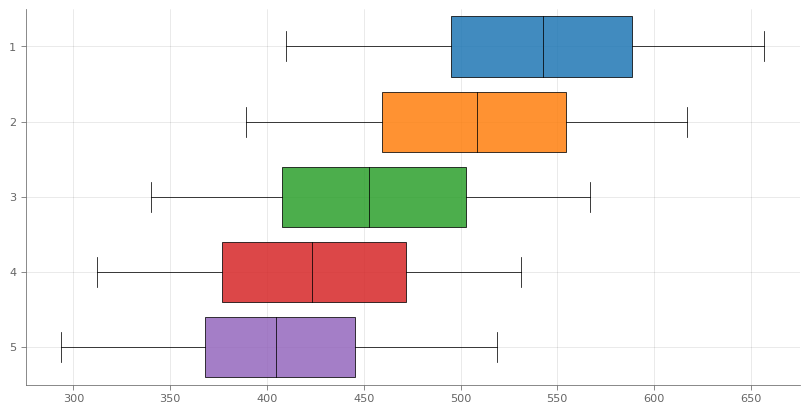

In [109]:
fig, ax = plt.subplots()

props = dict(linewidth=0.6, color='black')
pal = sns.color_palette(n_colors=5)

boxes = ax.bxp(boxplots, vert=False, positions=range(6, 1, -1), widths=0.8, patch_artist=True, medianprops=props, boxprops=dict(linewidth=0.6, edgecolor='black'), whiskerprops=props, capprops=props)
for i, bx in enumerate(boxes['boxes']):
    bx.set_facecolor([*pal[i], 0.85])
None

In [110]:
boxplots

[{'label': 1,
  'fliers': [],
  'med': 542.6102966308594,
  'q1': 495.2695037841797,
  'q3': 588.41728515625,
  'whislo': 409.78710021972654,
  'whishi': 656.9621887207031},
 {'label': 2,
  'fliers': [],
  'med': 508.4195953369141,
  'q1': 459.66139831542966,
  'q3': 554.3580871582031,
  'whislo': 389.07439575195315,
  'whishi': 617.1900085449219},
 {'label': 3,
  'fliers': [],
  'med': 452.7486968994141,
  'q1': 408.0041015625,
  'q3': 503.0759002685547,
  'whislo': 339.9404998779297,
  'whishi': 567.0766967773437},
 {'label': 4,
  'fliers': [],
  'med': 423.2319000244141,
  'q1': 376.51520080566405,
  'q3': 471.8629974365234,
  'whislo': 312.0891998291016,
  'whishi': 531.4715942382812},
 {'label': 5,
  'fliers': [],
  'med': 404.86570129394534,
  'q1': 367.9947967529297,
  'q3': 445.3336975097656,
  'whislo': 293.4135986328125,
  'whishi': 519.075894165039}]

In [89]:
pal[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [51]:
foo['boxes']

In [2]:
stata_setup.config('/mnt/c/Program Files/Stata17/', 'be', os_system='Windows')

TypeError: config() got an unexpected keyword argument 'os_system'

In [4]:
import sys
import os

In [18]:
import platform

In [20]:
platform.system()

'Linux'

In [14]:
os.listdir('/mnt/c/Program Files/Stata17/utilities')

['DLXAPI64.DLL',
 'icudt54l.dat',
 'jar',
 'java',
 'openmp',
 'pystata',
 'StataAdministrativeTools-64.exe',
 'std2dlib-x64.dll',
 'theme-x64.dll',
 'update']

In [5]:
sys.path.append('/mnt/c/Program Files/Stata17/utilities')

In [6]:
from pystata import config

In [7]:
config.init('be', os_system='Windows')

SystemError: failed to load Stata's shared library